In [1]:
# project: p6
# submitter: maolson8
# partner: none
# hours: 12

In [2]:
import pandas as pd
import geopandas as gpd
import geopy
import sqlite3
import os
from zipfile import ZipFile, ZIP_DEFLATED
from io import TextIOWrapper
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.geometry import box
from graphviz import Digraph, Graph
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
import rasterio
from rasterio.mask import mask

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
counties = gpd.read_file('counties.geojson')
tracts = gpd.read_file('tracts.geojson')

In [4]:
counties

,NAME,POP100,geometry
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669..."
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422..."
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338..."
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379..."
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192..."
...,...,...,...
67,Washburn County,15911,"POLYGON ((-91.55065 46.07034, -91.55065 46.070..."
68,Monroe County,44673,"POLYGON ((-90.55246 43.72565, -90.55096 43.725..."
69,Richland County,18021,"POLYGON ((-90.31107 43.55399, -90.31108 43.553..."
70,Price County,14159,"POLYGON ((-90.04485 45.81765, -90.04440 45.830..."


In [5]:
path = "counties_tracts.db"
assert os.path.exists(path)
conn = sqlite3.connect(path)
conn

In [6]:
counties_tracts = pd.read_sql("SELECT * FROM sqlite_master", conn)
counties_tracts

,type,name,tbl_name,rootpage,sql
0,table,counties,counties,2,"CREATE TABLE ""counties"" (\n""index"" INTEGER,\n ..."
1,index,ix_counties_index,counties,3,"CREATE INDEX ""ix_counties_index""ON ""counties"" ..."
2,table,tracts,tracts,4,"CREATE TABLE ""tracts"" (\n""index"" INTEGER,\n ""..."
3,index,ix_tracts_index,tracts,5,"CREATE INDEX ""ix_tracts_index""ON ""tracts"" (""in..."


In [7]:
for code in counties_tracts["sql"]:
    print(code + "\n")

CREATE TABLE "counties" (
"index" INTEGER,
  "NAME" TEXT,
  "COUNTY" TEXT,
  "AREALAND" INTEGER,
  "AREAWATER" INTEGER
)

CREATE INDEX "ix_counties_index"ON "counties" ("index")

CREATE TABLE "tracts" (
"index" INTEGER,
  "NAME" TEXT,
  "COUNTY" TEXT,
  "HU100" INTEGER
)

CREATE INDEX "ix_tracts_index"ON "tracts" ("index")



In [8]:
pd.read_sql("SELECT * FROM counties", conn)

,index,NAME,COUNTY,AREALAND,AREAWATER
0,0,Racine County,101,861533739,1190103013
1,1,Clark County,019,3133378070,23239614
2,2,Wood County,141,2054044751,41994799
3,3,Rusk County,107,2366092584,44813690
4,4,Ozaukee County,089,603514413,2287415379
...,...,...,...,...,...
67,67,Washburn County,129,2064515991,145563849
68,68,Monroe County,081,2333270295,18986835
69,69,Richland County,103,1518120276,8153423
70,70,Price County,099,3248866440,62102368


In [9]:
with ZipFile('land.zip') as zf:
    for info in zf.infolist():
        filename = info.filename
        print(filename)

wi.tif


In [10]:
land = rasterio.open("zip://../p6/land.zip!wi.tif")


In [11]:
#q1
len(counties.groupby('NAME'))

72

Text(0.5, 1.0, 'Population per County in WI')

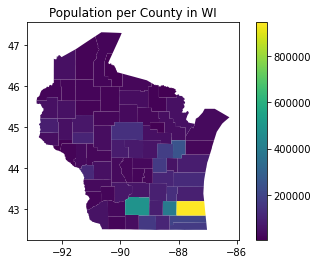

In [12]:
#q2
ax = counties.plot(cmap='viridis', column='POP100', legend=True)
ax.set_title('Population per County in WI')

In [13]:
county_area = pd.read_sql("""
SELECT NAME, AREALAND
FROM counties
GROUP BY COUNTY
""", conn)
arealand_series = pd.Series(county_area.AREALAND.values,index=county_area.NAME)

In [14]:
counties.head()

,NAME,POP100,geometry
0,Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669..."
1,Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422..."
2,Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338..."
3,Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379..."
4,Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192..."


In [15]:
arealand_series.name='arealand'

In [16]:
counties_2 = counties.join(arealand_series, on='NAME')

In [17]:
pd.read_sql("SELECT * FROM tracts", conn)

,index,NAME,COUNTY,HU100
0,0,Census Tract 9701.01,085,2760
1,1,Census Tract 9710.01,085,1536
2,2,Census Tract 9706.01,085,1208
3,3,Census Tract 9706.02,085,3136
4,4,Census Tract 4301,131,2144
...,...,...,...,...
1404,1404,Census Tract 14,059,2913
1405,1405,Census Tract 15,059,1550
1406,1406,Census Tract 16,059,1286
1407,1407,Census Tract 17,059,1068


In [18]:
pd.read_sql("SELECT * FROM counties", conn)

,index,NAME,COUNTY,AREALAND,AREAWATER
0,0,Racine County,101,861533739,1190103013
1,1,Clark County,019,3133378070,23239614
2,2,Wood County,141,2054044751,41994799
3,3,Rusk County,107,2366092584,44813690
4,4,Ozaukee County,089,603514413,2287415379
...,...,...,...,...,...
67,67,Washburn County,129,2064515991,145563849
68,68,Monroe County,081,2333270295,18986835
69,69,Richland County,103,1518120276,8153423
70,70,Price County,099,3248866440,62102368


In [19]:
dfhu100 = pd.read_sql("""
SELECT counties.NAME, SUM(HU100) AS SUM_HU100
FROM tracts INNER JOIN counties
ON counties.COUNTY = tracts.COUNTY
GROUP BY counties.NAME
  """,
  conn)
dfhu100

,NAME,SUM_HU100
0,Adams County,17436
1,Ashland County,9656
2,Barron County,23614
3,Bayfield County,12999
4,Brown County,104371
...,...,...
67,Waukesha County,160864
68,Waupaca County,25396
69,Waushara County,14843
70,Winnebago County,73329


In [20]:
counties_2=counties_2.set_index('NAME')

In [21]:
counties_2

,POP100,geometry,arealand
NAME,,,
Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739
Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",3133378070
Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338...",2054044751
Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",2366092584
Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",603514413
...,...,...,...
Washburn County,15911,"POLYGON ((-91.55065 46.07034, -91.55065 46.070...",2064515991
Monroe County,44673,"POLYGON ((-90.55246 43.72565, -90.55096 43.725...",2333270295
Richland County,18021,"POLYGON ((-90.31107 43.55399, -90.31108 43.553...",1518120276


In [22]:
train, test = train_test_split(counties_2, random_state=320, test_size=0.25)

In [23]:
#q3
counties_list = test.index.values.tolist()
counties_list

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [24]:
#q4
model = LinearRegression()
model.fit(train[['arealand']], train['POP100'])
score = model.score(test[['arealand']], test['POP100'])
score

0.022002661530554857

In [25]:
#q5
predict_pop = pd.DataFrame({'area': [500 * 2.59 * 1e6]})
predict_pop['exp_population'] = model.predict(predict_pop)
pop_at_500 = predict_pop.iat[0, 1]
pop_at_500

/home/madelineolson/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- area
Feature names seen at fit time, yet now missing:
- arealand

  warnings.warn(message, FutureWarning)


82032.53073541154

In [26]:
hu100_series = pd.Series(dfhu100["SUM_HU100"].values,index=dfhu100.NAME)
counties_2['sum_hu100'] = hu100_series
counties_2

,POP100,geometry,arealand,sum_hu100
NAME,,,,
Racine County,195408,"POLYGON ((-88.07073 42.66976, -88.06897 42.669...",861533739,82164
Clark County,34690,"POLYGON ((-90.55875 44.42221, -90.53398 44.422...",3133378070,15076
Wood County,74749,"POLYGON ((-89.72464 44.33712, -89.72460 44.338...",2054044751,34088
Rusk County,14755,"POLYGON ((-90.92517 45.37935, -90.92515 45.379...",2366092584,8883
Ozaukee County,86395,"POLYGON ((-87.89269 43.19202, -87.89265 43.192...",603514413,36267
...,...,...,...,...
Washburn County,15911,"POLYGON ((-91.55065 46.07034, -91.55065 46.070...",2064515991,12979
Monroe County,44673,"POLYGON ((-90.55246 43.72565, -90.55096 43.725...",2333270295,19204
Richland County,18021,"POLYGON ((-90.31107 43.55399, -90.31108 43.553...",1518120276,8868


In [27]:
train, test = train_test_split(counties_2, random_state=320, test_size=0.25)

In [28]:
#q6
counties_list2 = test.index.values.tolist()
counties_list2

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [29]:
train['sum_hu100']

NAME
Walworth County        51531
Marquette County        9896
Racine County          82164
Waupaca County         25396
Lincoln County         16784
Washburn County        12979
Door County            23966
Waukesha County       160864
Sheboygan County       50766
La Crosse County       48402
Langlade County        12360
Marathon County        57734
Jefferson County       35147
Price County           11120
Vilas County           25116
Columbia County        26137
Ozaukee County         36267
Fond du Lac County     43910
Crawford County         8802
Lafayette County        7230
Green County           15856
Marinette County       30379
Vernon County          13720
Douglas County         22825
Rock County            68422
Iowa County            10719
Dane County           216022
Bayfield County        12999
Polk County            24248
Trempealeau County     12619
Brown County          104371
Washington County      54695
Chippewa County        27185
Oconto County          23537
Richland 

In [30]:
#q7
hu100_dict = train['sum_hu100'].to_dict()
hu100_dict

{'Walworth County': 51531,
 'Marquette County': 9896,
 'Racine County': 82164,
 'Waupaca County': 25396,
 'Lincoln County': 16784,
 'Washburn County': 12979,
 'Door County': 23966,
 'Waukesha County': 160864,
 'Sheboygan County': 50766,
 'La Crosse County': 48402,
 'Langlade County': 12360,
 'Marathon County': 57734,
 'Jefferson County': 35147,
 'Price County': 11120,
 'Vilas County': 25116,
 'Columbia County': 26137,
 'Ozaukee County': 36267,
 'Fond du Lac County': 43910,
 'Crawford County': 8802,
 'Lafayette County': 7230,
 'Green County': 15856,
 'Marinette County': 30379,
 'Vernon County': 13720,
 'Douglas County': 22825,
 'Rock County': 68422,
 'Iowa County': 10719,
 'Dane County': 216022,
 'Bayfield County': 12999,
 'Polk County': 24248,
 'Trempealeau County': 12619,
 'Brown County': 104371,
 'Washington County': 54695,
 'Chippewa County': 27185,
 'Oconto County': 23537,
 'Richland County': 8868,
 'Portage County': 30054,
 'Sawyer County': 15975,
 'Menominee County': 2253,
 'Barr

In [31]:
#q8
model = LinearRegression()
model.fit(train[['sum_hu100']], train['POP100'])

scores = cross_val_score(model, train[['sum_hu100']], train['POP100'])
np.average(scores)

0.9652534544116037

In [32]:
#q9
scores.std()

0.03704265206670459

In [33]:
#q10
f"POP100 = {round(model.coef_[0], 2)}*HU100 + {round(model.intercept_, 2)}"

'POP100 = 2.39*HU100 + -7910.46'

In [34]:
predict_df = pd.DataFrame({"POP": range(1, 450000)})
predict_df["predicted_y"] = model.predict(predict_df)
predict_df.head()

/home/madelineolson/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- POP
Feature names seen at fit time, yet now missing:
- sum_hu100

  warnings.warn(message, FutureWarning)


,POP,predicted_y
0,1,-7908.070410
1,2,-7905.684378
2,3,-7903.298347
3,4,-7900.912315
4,5,-7898.526284


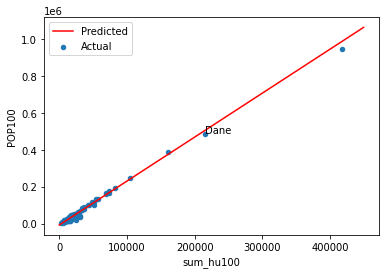

In [35]:
#q11
dane_xcoord = counties_2.loc['Dane County']['sum_hu100']
dane_ycoord = counties_2.loc['Dane County']['POP100']
ax = predict_df.plot.line(x="POP", y="predicted_y", color="red")
ax = counties_2.plot.scatter(x="sum_hu100", y="POP100", ax=ax)
ax.text(dane_xcoord, dane_ycoord, 'Dane')
ax.legend(['Predicted', 'Actual'])

In [36]:
counties_2.loc['Dane County']

POP100                                                  488073
geometry     POLYGON ((-89.01202099999843 43.11089599998475...
arealand                                            3100993706
sum_hu100                                               216022
Name: Dane County, dtype: object

In [37]:
A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

In [38]:
#q12
nums=[2,3,4,5]
np.isin(A, nums).astype(int).sum()

12

In [39]:
land

<open DatasetReader name='zip://../p6/land.zip!wi.tif' mode='r'>

In [40]:
mlwke = counties_2.loc['Milwaukee County']['geometry']
mlwke_gdf = gpd.GeoDataFrame(geometry = [mlwke])
mlwke_gdf.crs = 'EPSG:4326'

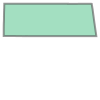

In [41]:
mlwke

In [42]:
matrix, _ = mask(land, mlwke_gdf.to_crs(land.crs)['geometry'], crop=True)
matrix = matrix[0]

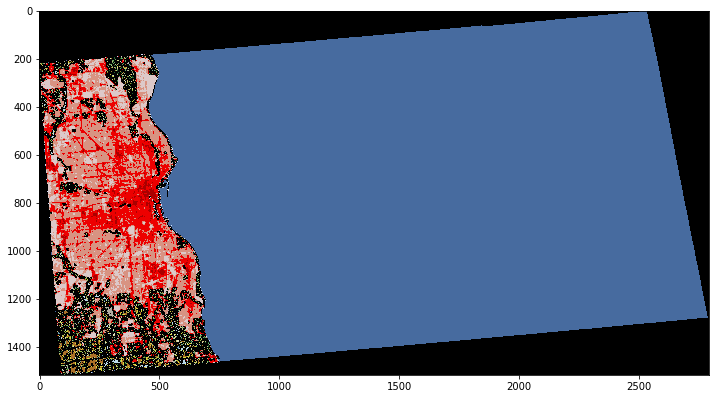

In [43]:
#q13


from matplotlib.colors import ListedColormap

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)


fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(matrix, vmin=0, vmax=255, cmap=custom_cmap)

In [44]:
land_use = {"open_water": 11,
            "ice_snow": 12,
            "developed_open": 21,
            "developed_low": 22,
            "developed_med": 23,
            "developed_high": 24,
            "barren": 31,
            "deciduous": 41,
            "evergreen": 42,
            "mixed_forest": 43,
            "dwarf_scrub": 51,
            "shrub_scrub": 52,
            "grassland": 71,
            "sedge": 72,
            "lichens": 73,
            "moss": 74,
            "pasture": 81,
            "crops": 82,
            "woody_wetlands": 90,
            "herbacious_wetlands": 95}

In [45]:
#q14
water = land_use['open_water']
(matrix == water).sum() / (matrix > 0).sum()

0.7963037455950543

In [46]:

evergreen = land_use['evergreen']
matrix == evergreen

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [47]:
evergreen_dict = {}
all_counties = counties_2.index.values.tolist()
for county in all_counties:
    evergreen = land_use['evergreen']

    row = counties_2.loc[county]['geometry']
    row_gdf = gpd.GeoDataFrame(geometry = [row])
    row_gdf.crs = 'EPSG:4326'
    
    matrix, _ = mask(land, row_gdf.to_crs(land.crs)['geometry'], crop=True)
    matrix = matrix[0]
    
    total = (matrix == evergreen).sum()
    
    evergreen_dict[county] = total

evergreen_dict
evg_s = pd.Series(evergreen_dict)

counties_2['evergreen_per_county'] = evg_s

Text(0.5, 0, 'Amount of Evergreen per County')

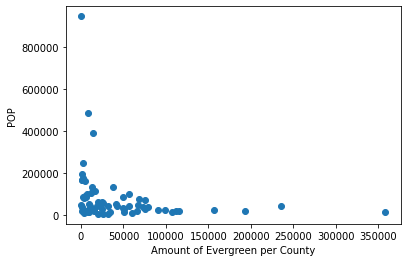

In [48]:
#q15
plt.scatter(counties_2['evergreen_per_county'], counties_2['POP100'])
plt.ylabel('POP')
plt.xlabel('Amount of Evergreen per County')

In [49]:
tracts

,GEOID,POP100,geometry
0,55001950204,1646,"POLYGON ((-90.02638 44.08721, -90.02628 44.086..."
1,55009940002,4698,"POLYGON ((-88.15018 44.51202, -88.15011 44.509..."
2,55061990000,0,"POLYGON ((-87.53727 44.33179, -87.53920 44.327..."
3,55009020100,5817,"POLYGON ((-87.93753 44.67821, -87.93742 44.630..."
4,55009010100,6506,"POLYGON ((-88.06825 44.45368, -88.06830 44.453..."
...,...,...,...
1537,55139003100,2046,"POLYGON ((-88.47454 44.19198, -88.47453 44.191..."
1538,55079017900,2879,"POLYGON ((-87.91064 42.99520, -87.91063 42.995..."
1539,55059000800,2763,"POLYGON ((-87.84574 42.60276, -87.84574 42.602..."
1540,55025013700,7107,"POLYGON ((-89.57788 42.98135, -89.57789 42.980..."


In [50]:
tracts_crs = tracts.to_crs(land.crs)
tracts_crs

,GEOID,POP100,geometry
0,55001950204,1646,"POLYGON ((476459.321 2359023.337, 476473.960 2..."
1,55009940002,4698,"POLYGON ((621899.492 2417088.085, 621933.445 2..."
2,55061990000,0,"POLYGON ((672119.958 2401253.560, 672008.945 2..."
3,55009020100,5817,"POLYGON ((637138.410 2436942.838, 637597.840 2..."
4,55009010100,6506,"POLYGON ((628917.973 2411150.565, 628914.301 2..."
...,...,...,...
1537,55139003100,2046,"POLYGON ((599079.049 2379457.015, 599080.426 2..."
1538,55079017900,2879,"POLYGON ((655219.585 2250069.887, 655220.915 2..."
1539,55059000800,2763,"POLYGON ((664221.429 2206827.091, 664222.654 2..."
1540,55025013700,7107,"POLYGON ((520513.435 2238213.310, 520518.480 2..."


In [51]:
for row in tracts_crs.itertuples():
    
    mixed = land_use['mixed_forest']
    evergreen = land_use['evergreen']
    deciduous = land_use['deciduous']

    water = land_use['open_water']
    
    
    high_dev = land_use['developed_high']
    med_dev = land_use['developed_med']
    low_dev = land_use['developed_low']


    
    matrix, _ = mask(land, [row.geometry], crop=True)
    matrix = matrix[0]
    
    tot_high = (matrix == high_dev).sum()
    tot_med = (matrix == med_dev).sum()
    tot_low = (matrix == low_dev).sum()
    
    tot_mix = (matrix == mixed).sum()
    tot_ever = (matrix == evergreen).sum()
    tot_decid = (matrix == deciduous).sum()

    tot_water = (matrix == water).sum()

    
    

    
    tracts.at[row.Index, 'high_dev'] = tot_high
    tracts.at[row.Index, 'medium_dev'] = tot_med
    tracts.at[row.Index, 'low_dev'] = tot_low
    
    tracts.at[row.Index, 'mixed_forest'] = tot_mix
    tracts.at[row.Index, 'evergreen'] = tot_ever
    tracts.at[row.Index, 'deciduous'] = tot_decid

    
    tracts.at[row.Index, 'open_water'] = tot_water


tracts

,GEOID,POP100,geometry,high_dev,medium_dev,low_dev,mixed_forest,evergreen,deciduous,open_water
0,55001950204,1646,"POLYGON ((-90.02638 44.08721, -90.02628 44.086...",104.0,833.0,5402.0,39462.0,36471.0,62714.0,55465.0
1,55009940002,4698,"POLYGON ((-88.15018 44.51202, -88.15011 44.509...",243.0,1211.0,2104.0,107.0,7.0,2619.0,57.0
2,55061990000,0,"POLYGON ((-87.53727 44.33179, -87.53920 44.327...",0.0,0.0,0.0,0.0,0.0,0.0,2107187.0
3,55009020100,5817,"POLYGON ((-87.93753 44.67821, -87.93742 44.630...",337.0,1971.0,7738.0,426.0,196.0,6347.0,117008.0
4,55009010100,6506,"POLYGON ((-88.06825 44.45368, -88.06830 44.453...",174.0,1109.0,2711.0,0.0,0.0,0.0,530.0
...,...,...,...,...,...,...,...,...,...,...
1537,55139003100,2046,"POLYGON ((-88.47454 44.19198, -88.47453 44.191...",299.0,467.0,676.0,0.0,0.0,34.0,2848.0
1538,55079017900,2879,"POLYGON ((-87.91064 42.99520, -87.91063 42.995...",153.0,491.0,38.0,0.0,0.0,0.0,0.0
1539,55059000800,2763,"POLYGON ((-87.84574 42.60276, -87.84574 42.602...",200.0,748.0,163.0,0.0,0.0,0.0,0.0
1540,55025013700,7107,"POLYGON ((-89.57788 42.98135, -89.57789 42.980...",477.0,1799.0,2209.0,519.0,280.0,1654.0,329.0


In [52]:
train1, test1 = train_test_split(tracts, random_state=320, test_size=0.25)

In [53]:
train1

,GEOID,POP100,geometry,high_dev,medium_dev,low_dev,mixed_forest,evergreen,deciduous,open_water
1081,55009000303,2806,"POLYGON ((-88.07404 44.53257, -88.07473 44.531...",278.0,658.0,793.0,0.0,0.0,8.0,0.0
446,55087010501,2505,"POLYGON ((-88.39829 44.26799, -88.39829 44.267...",214.0,456.0,772.0,2.0,0.0,41.0,65.0
1475,55003950500,2212,"POLYGON ((-90.92834 46.28435, -90.92833 46.284...",108.0,791.0,4664.0,82461.0,7410.0,139939.0,3143.0
350,55115100700,3074,"POLYGON ((-89.13242 44.96517, -89.13243 44.965...",216.0,964.0,3079.0,25022.0,1362.0,110946.0,668.0
1369,55025991702,0,"POLYGON ((-89.48377 43.09381, -89.48373 43.093...",19.0,25.0,26.0,18.0,9.0,38.0,44182.0
...,...,...,...,...,...,...,...,...,...,...
1425,55079017400,2878,"POLYGON ((-87.94443 43.00317, -87.94453 43.003...",90.0,261.0,13.0,0.0,0.0,0.0,0.0
1390,55105002300,1870,"POLYGON ((-89.04001 42.54016, -89.03921 42.531...",99.0,344.0,1161.0,0.0,0.0,29.0,259.0
781,55133203105,3385,"POLYGON ((-88.30439 43.04607, -88.30448 43.041...",138.0,751.0,1373.0,69.0,6.0,416.0,0.0
1157,55135100100,3719,"POLYGON ((-88.94765 44.67483, -88.94758 44.674...",402.0,1312.0,3500.0,6885.0,3545.0,18980.0,2113.0


In [54]:

# score3 = model3.score(test1[['open_water']], test1['POP100'])
# score3

In [55]:
model1 = LinearRegression()
model1.fit(train1[['mixed_forest', 'evergreen', 'deciduous']], train1['POP100'])

model2 = LinearRegression()
model2.fit(train1[['high_dev', 'medium_dev', 'low_dev']], train1['POP100'])

model3 = LinearRegression()
model3.fit(train1[['open_water']], train1['POP100'])

scores2 = cross_val_score(model1, train1[['high_dev', 'medium_dev', 'low_dev']], train1['POP100'])
scores3 = cross_val_score(model1, train1[['open_water']], train1['POP100'])

Text(0, 0.5, 'R^2 Score')

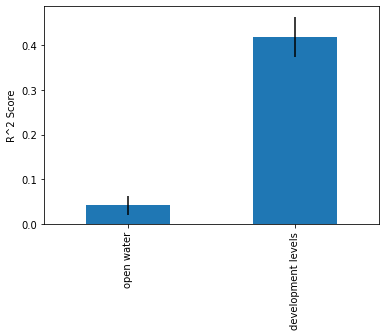

In [56]:
#q16
avg = pd.Series({"open water": scores3.mean(), "development levels": scores2.mean()})
std = pd.Series({"open water": scores3.std(), "development levels": scores2.std()})
ax = avg.plot.bar(yerr=std)
ax.set_ylabel("R^2 Score")

In [57]:
score_mod3 = model3.score(test1[['open_water']], test1['POP100'])
score_mod3

0.028304831564443078

In [58]:
#q17

#I would reccommend model2 over model3 because the test r2 score is 0.369 compared to r2 for open water predictor
# on model 3 which is only 0.028. This means that model3 which predicts based on high, low, med development
#  is far more accurate prediction of population.

score_mod2 = model2.score(test1[['high_dev', 'medium_dev', 'low_dev']], test1['POP100'])
score_mod2

0.36943409561855023